### Fashion MNIST - Image Classification - with CNN 

**NOTE:** This notebook reads an existing model from file and tests on data. 

In [110]:
IMG_ROWS = 28
IMG_COLS = 28
NUM_CLASSES = 10

In [111]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio
from keras.datasets import fashion_mnist
import numpy as np
import pandas as pd
from keras.utils import plot_model, to_categorical
from tensorflow.python.keras.models import model_from_json, load_model
import os

Set **CURRENT_MODEL_IDX** to a value from the interval [0,6] according to the information below:
- 0: basic DNN, no convolution, no regularization, etc.
- 1: basic CNN, no regularization, etc.
- 2: CNN with dropout. (best)
- 3: CNN with dropout + L2 regularization.
- 4: CNN with dropout + stride number increased.
- 5: CNN with dropout + learning rate decay.
- 6: CNN with dropout + Nadam optimizer.

In [112]:
CURRENT_MODEL_IDX = 2
MODEL_IN_DIR = 'saved_models'
MODEL_HISTORY_IN_DIR = 'saved_model_histories'
TEST_OUT_DIR = 'outfiles'

In [113]:
model_type_str = 'dnn' if CURRENT_MODEL_IDX==0 else 'cnn'
idx_str = str(CURRENT_MODEL_IDX) if CURRENT_MODEL_IDX>0 else ''
current_model_name = model_type_str+idx_str+'_model'

In [114]:
current_model_name

'cnn2_model'

In [115]:
test_model_out_dir = TEST_OUT_DIR + '/' + current_model_name + '_out'
if not os.path.exists(test_model_out_dir):
    os.mkdir(test_model_out_dir)

In [116]:
model_history_path = MODEL_HISTORY_IN_DIR + '/' + current_model_name+'_history.json'
model_path = MODEL_IN_DIR + '/' + current_model_name+'.h5'

In [117]:
print(model_history_path)
print(model_path)

saved_model_histories/cnn2_model_history.json
saved_models/cnn2_model.h5


**Functions for data processing and plotting the results** 

In [118]:
# data preprocessing
def data_preprocessing(data):
    out_y = to_categorical(data.label, NUM_CLASSES)
    num_images = data.shape[0]
    x_as_array = data.values[:,1:] # take all rows, take columns except the first column (label)
    x_shaped_array = x_as_array.reshape(num_images, IMG_ROWS, IMG_COLS, 1)
    out_x = x_shaped_array / 255
    return out_x, out_y

In [119]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    plt_cp = plt.gcf()
    return plt_cp

In [120]:
# Create a dataframe from train data (x and y)
# merge label and pixel array,create a dataframe, of size (60000, 785). 
# Dataframe: 60000 rows. Each row holds label, pixel1, pixel2, ..., pixel784.
def create_dataframe(x_data,y_data):
    y_data_list = y_data.tolist()
    y_data_adjusted = np.array([y_data_list]) # needed step for contatenation
    num_images = x_data.shape[0] 
    x_data_array  = x_data.reshape(num_images, IMG_ROWS*IMG_COLS)
    data_array = np.concatenate((y_data_adjusted.T, x_data_array), axis=1)
    pixel_idx = range(1,IMG_ROWS*IMG_COLS+1) 
    pixel_names = ['pixel' + str(i) for i in pixel_idx]
    columns = ['label'] + pixel_names
    data_df = pd.DataFrame(data_array, columns = columns) 
    return data_df

**Load model history**

In [121]:
def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace
    
def plot_accuracy_and_loss(hist):
    acc = hist['acc']
    val_acc = hist['val_acc']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))
    
    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
    
    
    #data = [trace_ta,trace_va,trace_tl,trace_vl]
    layout = go.Layout(
    title=go.layout.Title(
        text=current_model_name,
        xref='paper',
        x=0.5
    )
    )
    
    fig = go.Figure(layout=layout)
    
    fig = tools.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])
    
    iplot(fig, filename='accuracy-loss')
    return fig

In [122]:
def reformat_dict(my_dict):
    acc = [my_dict[i]['acc'] for i in range(len(my_dict))]
    val_acc = [my_dict[i]['val_acc'] for i in range(len(my_dict))]
    loss = [my_dict[i]['loss'] for i in range(len(my_dict))]
    val_loss = [my_dict[i]['val_loss'] for i in range(len(my_dict))]
    new_my_dict = {}
    new_my_dict['acc'] = acc
    new_my_dict['val_acc'] = val_acc
    new_my_dict['loss'] = loss
    new_my_dict['val_loss'] = val_loss
    return new_my_dict

In [123]:
model_hist_df = pd.read_json(model_history_path, orient='records')
model_hist_dict = model_hist_df.to_dict('records')
model_hist_dict_edited = reformat_dict(model_hist_dict)

**Plot model**

In [124]:
init_notebook_mode(connected=True)
hist_fig = plot_accuracy_and_loss(model_hist_dict_edited)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



**Load data**

In [125]:
(X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = fashion_mnist.load_data()

**Create dataframe from data**

In [126]:
#unique_lbls = list(set(y_train_raw.tolist()))
train_data_df = create_dataframe(X_train_raw, y_train_raw)
test_data_df = create_dataframe(X_test_raw, y_test_raw)

In [127]:
train_data_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,119,114,130,76,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,33,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Take unique labels**

In [128]:
unique_lbls = train_data_df.label.unique()
unique_lbls

array([9, 0, 3, 2, 7, 5, 1, 6, 4, 8])

**Preprocess data**

In [129]:
# prepare the data
X_train, y_train = data_preprocessing(train_data_df)
#print(len(X[0][:][:][0]))
X_test, y_test = data_preprocessing(test_data_df)

**Load existing model**

In [130]:
cnn_new_model = load_model(model_path)

In [131]:
m_summary = cnn_new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
__________

**Evaluate model and predict test data**

In [132]:
best_model = cnn_new_model
test_score = best_model.evaluate(X_test, y_test, verbose=0)
test_loss = test_score[0]
test_acc = test_score[1]
y_test_predicted = best_model.predict_classes(X_test)

**Report scores and results**

In [133]:
print('Classification report on test data:\n')
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
report_str = classification_report(y_test_raw, y_test_predicted, target_names=class_names)
report_str += '\naccuracy: {0:.2f}\n'.format(test_acc)
report_str += '\nloss: {0:.2f}\n'.format(test_loss)
print(report_str)

Classification report on test data:

              precision    recall  f1-score   support

 T-shirt/top       0.86      0.85      0.86      1000
     Trouser       1.00      0.97      0.98      1000
    Pullover       0.90      0.82      0.86      1000
       Dress       0.90      0.92      0.91      1000
        Coat       0.83      0.88      0.85      1000
      Sandal       0.99      0.95      0.97      1000
       Shirt       0.73      0.75      0.74      1000
     Sneaker       0.93      0.98      0.95      1000
         Bag       0.97      0.99      0.98      1000
  Ankle boot       0.97      0.96      0.96      1000

   micro avg       0.91      0.91      0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

accuracy: 0.91

loss: 0.26



**Plot confusion matrix**

Confusion matrix, without normalization


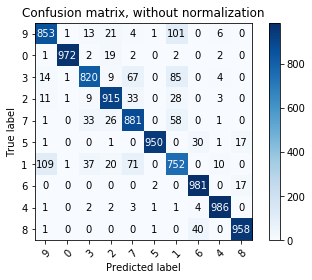

In [134]:

#cm = confusion_matrix(y_test_raw, y_test_predicted)
#plot_confusion_matrix(cm, unique_labels)
#plt = plot_confusion_matrix(y_test_raw, y_test_predicted, unique_lbls)
cm_plt = plot_confusion_matrix(y_test_raw, y_test_predicted, unique_lbls)

**Write test results to file**

Write model summary to file.

In [135]:
with open(test_model_out_dir + '/' + current_model_name + '_summary.txt','w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    cnn_new_model.summary(print_fn=lambda x: fh.write(x + '\n'))

Write classification report to file.

In [136]:
myfile = open(test_model_out_dir + '/' + current_model_name + '_out.txt', 'w')
myfile.write(report_str)
myfile.close()

Save confusion matrix as image.

In [137]:
cm_plt.savefig(test_model_out_dir + '/' + current_model_name + '_cm' + '.png')

Save model history plot as html file.

In [138]:
hist_file_name = test_model_out_dir + '/' + current_model_name + '_history.html'
plot(hist_fig, filename=hist_file_name, auto_open=False)
#pio.write_image(hist_fig, file= hist_file_name, format='png')
#static_image_bytes = pio.to_image(hist_fig, format='png')
#iplot(hist_fig, filename=hist_file_name, auto_play=False, image='png')
#py.image.save_as(hist_fig, current_model_name + '_hist' + '.png') 

'outfiles/cnn2_model_out/cnn2_model_history.html'